# LightGlue Based Image-Map Matching
this notebook is based on the [LightGlue Demo](https://github.com/cvg/LightGlue/blob/main/demo.ipynb)

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    if not Path("LightGlue").exists():
        !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    # !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

c:\Users\lerch\Coding\Kaggle\SE3-localization\LightGlue\lightglue\lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
# Check CUDA availability and set device appropriately
import torch
print(f"PyTorch version: {torch.__version__}")  
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("CUDA not available, using CPU")
    device = torch.device("cpu")

print(f"Using device: {device}")

PyTorch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using device: cuda


In [17]:
# max_num_keypoints=2048
max_num_keypoints = None
extractor = SuperPoint(max_num_keypoints = max_num_keypoints).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)


## Own example

In [18]:
data_path = Path("../data")
# Load images and move to device (works for both CUDA and CPU)
image_map = load_image(data_path / 'map.png').to(device)

In [26]:
# Read the training positions
import pandas as pd
import matplotlib.pyplot as plt
train_pos = pd.read_csv(data_path / 'train_data/train_pos.csv')

def extract_and_match(image0, image_map, map_features=None):
    feats0 = extractor.extract(image0)
    if map_features is not None:
        feats1 = map_features
    else:
        feats1 = extractor.extract(image_map)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    print(f"__Number of matches: {len(m_kpts0)}")
    return m_kpts0, m_kpts1, matches01, kpts0, kpts1

def get_ground_truth_positions(train_pos, img_path):
    # Get id from filename
    id = int(img_path.name.split('.')[0])
    # Get the ground truth positions for the current image
    gt_positions = train_pos[train_pos['id'] == id]
    gt_x = gt_positions.iloc[0]['x_pixel']
    gt_y = gt_positions.iloc[0]['y_pixel']
    return gt_x, gt_y, id

def get_zoomed_map(image_map, gt_x, gt_y, zoom_factor=5):
    # Get map dimensions
    map_height, map_width = image_map.shape[1], image_map.shape[2]
    
    # Calculate zoom window (4x zoom means 1/4 of original size)
    window_width = map_width // zoom_factor
    window_height = map_height // zoom_factor
    
    # Calculate crop boundaries centered on ground truth
    left = max(0, int(gt_x - window_width // 2))
    right = min(map_width, int(gt_x + window_width // 2))
    top = max(0, int(gt_y - window_height // 2))
    bottom = min(map_height, int(gt_y + window_height // 2))
    
    # Crop the map
    zoomed_map = image_map[:, top:bottom, left:right]

    # Adjust ground truth coordinates for the cropped image
    adj_gt_x = gt_x - left
    adj_gt_y = gt_y - top
    
    return zoomed_map, adj_gt_x, adj_gt_y

def get_map_tile_features(image_map, zoom_factor=5):
    """
    Extract features for map tiles at a specified zoom factor, creating a grid of tiles across the entire map.
    """
    # Get map dimensions
    map_height, map_width = image_map.shape[1], image_map.shape[2]
    
    # Calculate tile dimensions
    tile_width = map_width // zoom_factor
    tile_height = map_height // zoom_factor
    
    tile_features = []
    tile_positions = []
    tiles = []
    
    # Create grid of tiles
    for row in range(zoom_factor):
        for col in range(zoom_factor):
            # Calculate tile boundaries
            left = col * tile_width
            right = min((col + 1) * tile_width, map_width)
            top = row * tile_height
            bottom = min((row + 1) * tile_height, map_height)
            
            # Extract tile
            tile = image_map[:, top:bottom, left:right]
            
            # Extract features from the tile
            feats = extractor.extract(tile)
            feats = rbd(feats)  # remove batch dimension
            
            tile_features.append(feats)
            tile_positions.append({
                'row': row, 
                'col': col, 
                'left': left, 
                'right': right, 
                'top': top, 
                'bottom': bottom
            })
            tiles.append(tile)
    
    return tile_features, tile_positions, tiles

def plot_matches(image0, img_path, image_map, train_pos, zoom_factor=5, map_features=None, plot_gt=False):
    gt_x, gt_y, id = get_ground_truth_positions(train_pos, img_path)
    print(f"__Plotting ground truth for ID: {id}")
    print(f"__Ground truth position: ({gt_x:.1f}, {gt_y:.1f})")

    # Get zoomed map and adjusted ground truth coordinates
    if zoom_factor > 1:
        zoomed_map, adj_gt_x, adj_gt_y = get_zoomed_map(image_map, gt_x, gt_y, zoom_factor)
        image_map = zoomed_map.to(device)
        gt_x, gt_y = adj_gt_x, adj_gt_y

    # Extract and match keypoints
    m_kpts0, m_kpts1, matches01, kpts0, kpts1 = extract_and_match(image0, image_map, map_features)
    # Visualize the images
    _ = viz2d.plot_images([image0, image_map], titles=[f"Image {id}", f"Map (Zoom {zoom_factor}x)"])
    # Get the current figure and axes
    fig = plt.gcf()
    axes = fig.axes
    
    # Plot red dot on the map (image1) at ground truth position
    if plot_gt:
        axes[1].plot(gt_x, gt_y, 'ro', markersize=8, markeredgecolor='white', markeredgewidth=1)
        axes[1].text(gt_x + 20, gt_y - 20, f'GT ({gt_x:.0f}, {gt_y:.0f})', 
                    color='red', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    # Plot matches
    viz2d.plot_matches(m_kpts0, m_kpts1, color="blue", lw=0.3)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')
    plt.show()

    # # Plot pruned keypoints
    # kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
    # viz2d.plot_images([image0, image_map])
    # viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

In [ ]:
TEST_IMAGE_PATH = data_path / "test_data" / "test_images"
TRAIN_IMAGE_PATH = data_path / "train_data" / "train_images"

image_paths = sorted(TRAIN_IMAGE_PATH.iterdir())

# Run for x images in train_data with a step of 50
for i in range(0, len(image_paths), 300):
    img_path = image_paths[i]
    print(f"Processing image: {img_path.name}...")
    
    # Idea1: resize drone image to match the map size
    # -> Probem: feature matches not really near the ground truth
    image0 = load_image(img_path, resize=(1000, 1333)).to(device)
    
    # Idea2: split the map into tiles and extract features for each tile
    # -> ?
    map_features, map_tile_positions, tiles = get_map_tile_features(image_map, zoom_factor=5)
    for tile_feats, tile_pos, tile_img in zip(map_features, map_tile_positions, tiles):
        print(f"_Processing tile at row {tile_pos['row']}, col {tile_pos['col']}...")
        # map_features = tile_feats
        # Error when trying to use pre-computed features for the tile
        map_features = None
        plot_matches(image0, img_path, tile_img, train_pos, 
                     zoom_factor=1, map_features=map_features, plot_gt= False)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

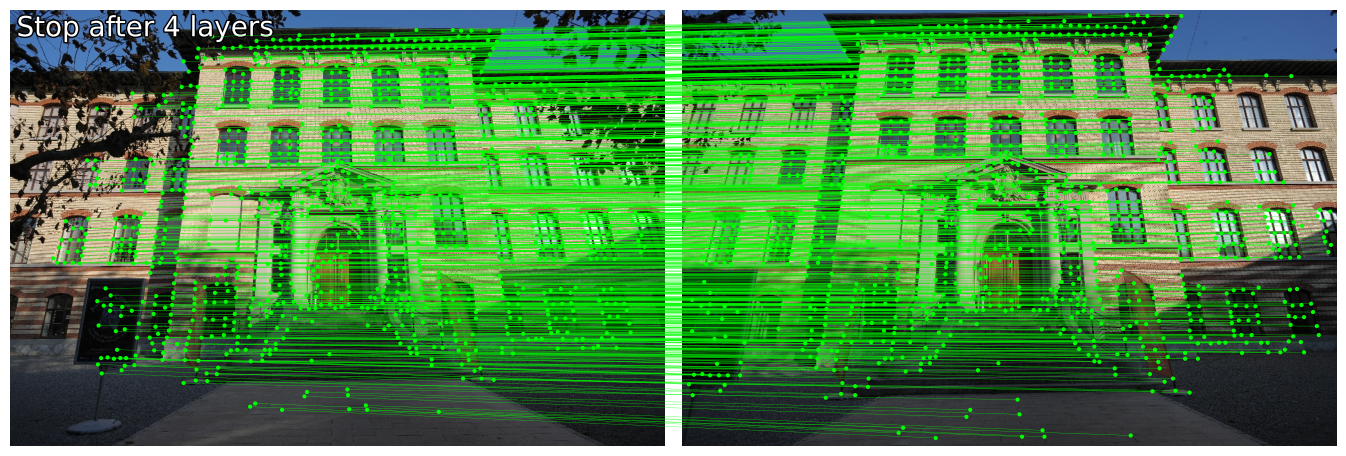

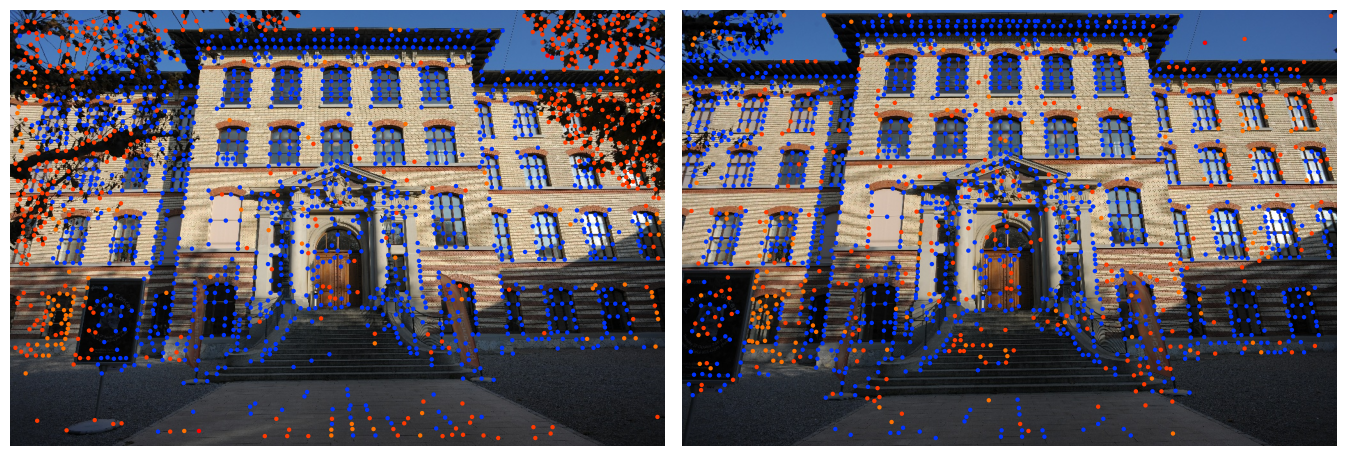

In [6]:
image0 = load_image(images / "DSC_0411.JPG")
image1 = load_image(images / "DSC_0410.JPG")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

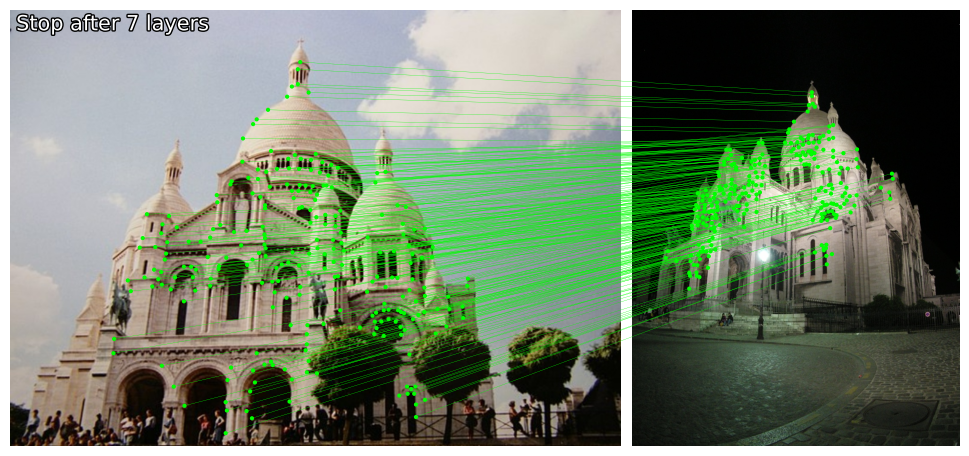

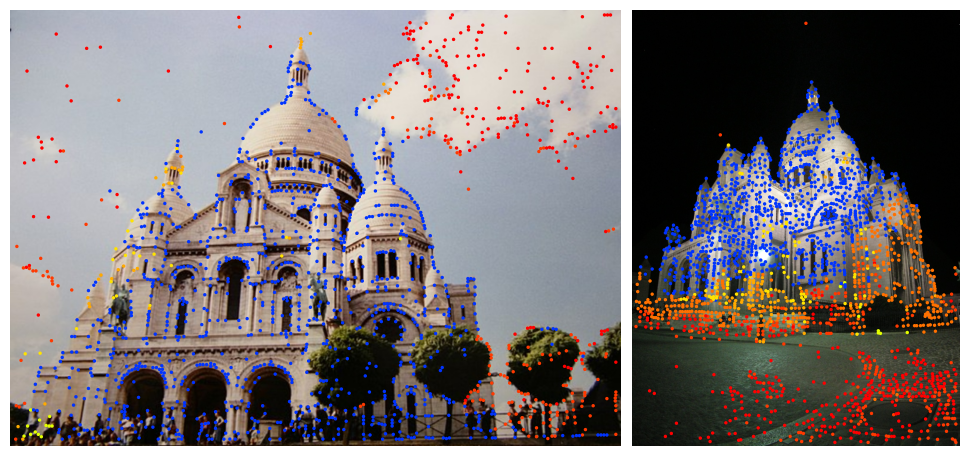

In [7]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

###  